/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Best Outer-CV MAE: -9.16
Best Parameters:
  reg__colsample_bytree = 0.8
  reg__learning_rate = 0.01
  reg__max_depth = 3
  reg__n_estimators = 200
  reg__subsample = 1.0
✓ Saved model → final_tonometry_model_xgb.pkl
Final MAE: 4.86
Final R² Score: 0.77


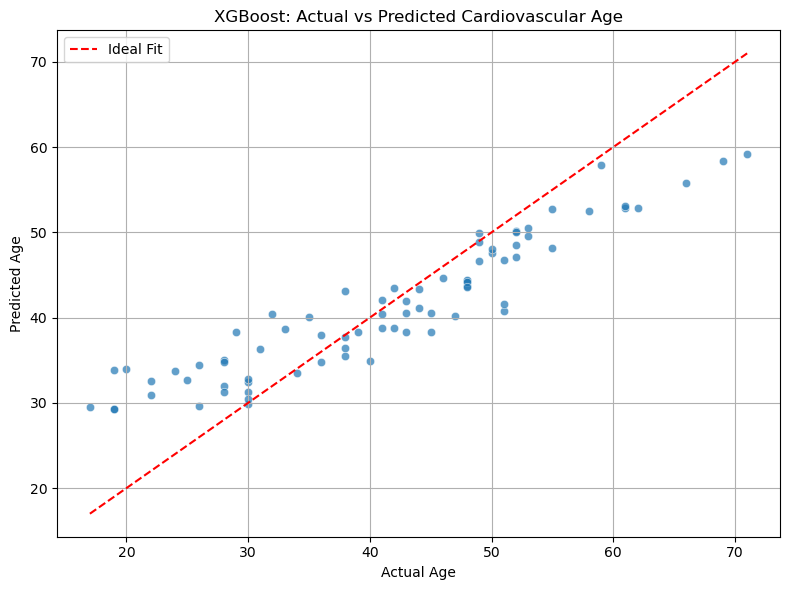

In [3]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv("cleaned_tonometry_dataset.csv")
X = df.drop(columns=["Age", "patient_id"], errors='ignore')
y = df["Age"]

# Preprocessing
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), X.columns)
])

# XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

pipeline = Pipeline([
    ("prep", preprocess),
    ("reg", xgb)
])

param_grid = {
    "reg__n_estimators": [100, 200],
    "reg__max_depth": [3, 5, 7],
    "reg__learning_rate": [0.01, 0.1],
    "reg__subsample": [0.8, 1.0],
    "reg__colsample_bytree": [0.8, 1.0],
}

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipeline, param_grid, cv=inner_cv,
                    scoring="neg_mean_absolute_error", n_jobs=-1)

cv_results = cross_validate(grid, X, y, cv=outer_cv,
                            scoring={"MAE": make_scorer(mean_absolute_error)},
                            return_estimator=True, n_jobs=-1)

best_idx = np.argmin(cv_results["test_MAE"])
best_params = cv_results["estimator"][best_idx].best_params_

print(f"Best Outer-CV MAE: {-cv_results['test_MAE'].mean():.2f}")
print("Best Parameters:")
for k, v in best_params.items():
    print(f"  {k} = {v}")

# Final training
best_xgb_params = {k.replace("reg__", ""): v for k, v in best_params.items()}
xgb_final = XGBRegressor(**best_xgb_params, objective='reg:squarederror', random_state=42, n_jobs=-1)

preprocess_final = preprocess.fit(X)
X_proc = preprocess_final.transform(X)
xgb_final.fit(X_proc, y)

final_model = make_pipeline(preprocess_final, xgb_final)
joblib.dump(final_model, "final_tonometry_model_xgb.pkl")
print("✓ Saved model → final_tonometry_model_xgb.pkl")

# Final evaluation
y_pred = final_model.predict(X)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Final MAE: {mae:.2f}")
print(f"Final R² Score: {r2:.2f}")

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("XGBoost: Actual vs Predicted Cardiovascular Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("xgb_predicted_vs_actual.png")
plt.show()
